# Calibration data analysis from one motor
Running single motor from full to empty 4x 1.5V rechargeable Lithium batteries.

Algorithm:
1. Measure voltage
2. Run motor for 3 seconds at random PWM
3. Measure speed
4. Stop motor for 100ms
5. Repeat until battery is empty

In [77]:
import pandas as pd

df = pd.read_csv('left_calibration.csv')
df.head()

,pwm,voltage,speed
0,176,2.202417,12.459220
1,163,2.204834,11.058830
2,42,2.194360,1.314481
3,240,2.200000,18.390820
4,202,2.195972,14.286200


### Data statistics

In [78]:
# Display df statistics
df.describe()

,pwm,voltage,speed
count,4137.000000,4137.000000,4137.000000
mean,124.857868,2.204326,8.170662
std,74.454052,0.006228,6.153037
min,0.000000,2.180664,0.000000
25%,60.000000,2.203223,2.677155
50%,123.000000,2.205640,7.877773
75%,190.000000,2.207251,13.351660
max,255.000000,2.256397,21.490380


### Voltage over time

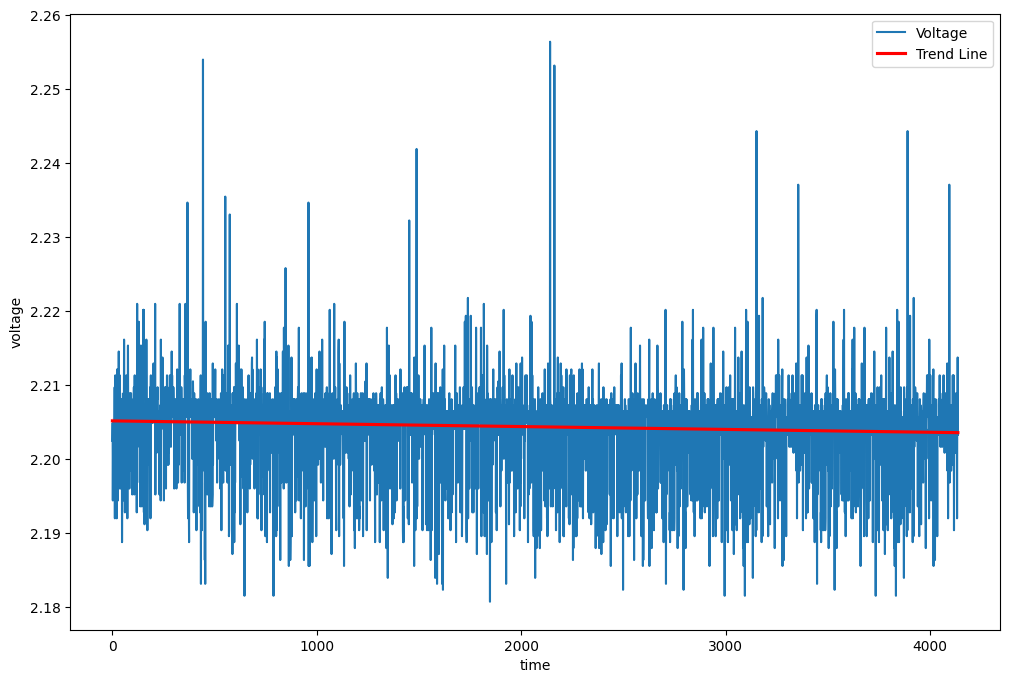

In [79]:
# Line plot voltage over time

import seaborn as sns
import matplotlib.pyplot as plt

df['time'] = range(0, len(df))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Line plot voltage over time
sns.lineplot(data=df, x='time', y='voltage', ax=ax, label='Voltage')

# Plot trend line
sns.regplot(data=df, x='time', y='voltage', ax=ax, scatter=False, color='red', label='Trend Line')

# Show plot
plt.legend()
plt.show()

### PWM to speed scattered plot with voltage as color
- When wheel starts spinning, function is almost linear except for high PWM. It seems PWM over 230 is like run at max speed, there is non-linear jump and than plateau.

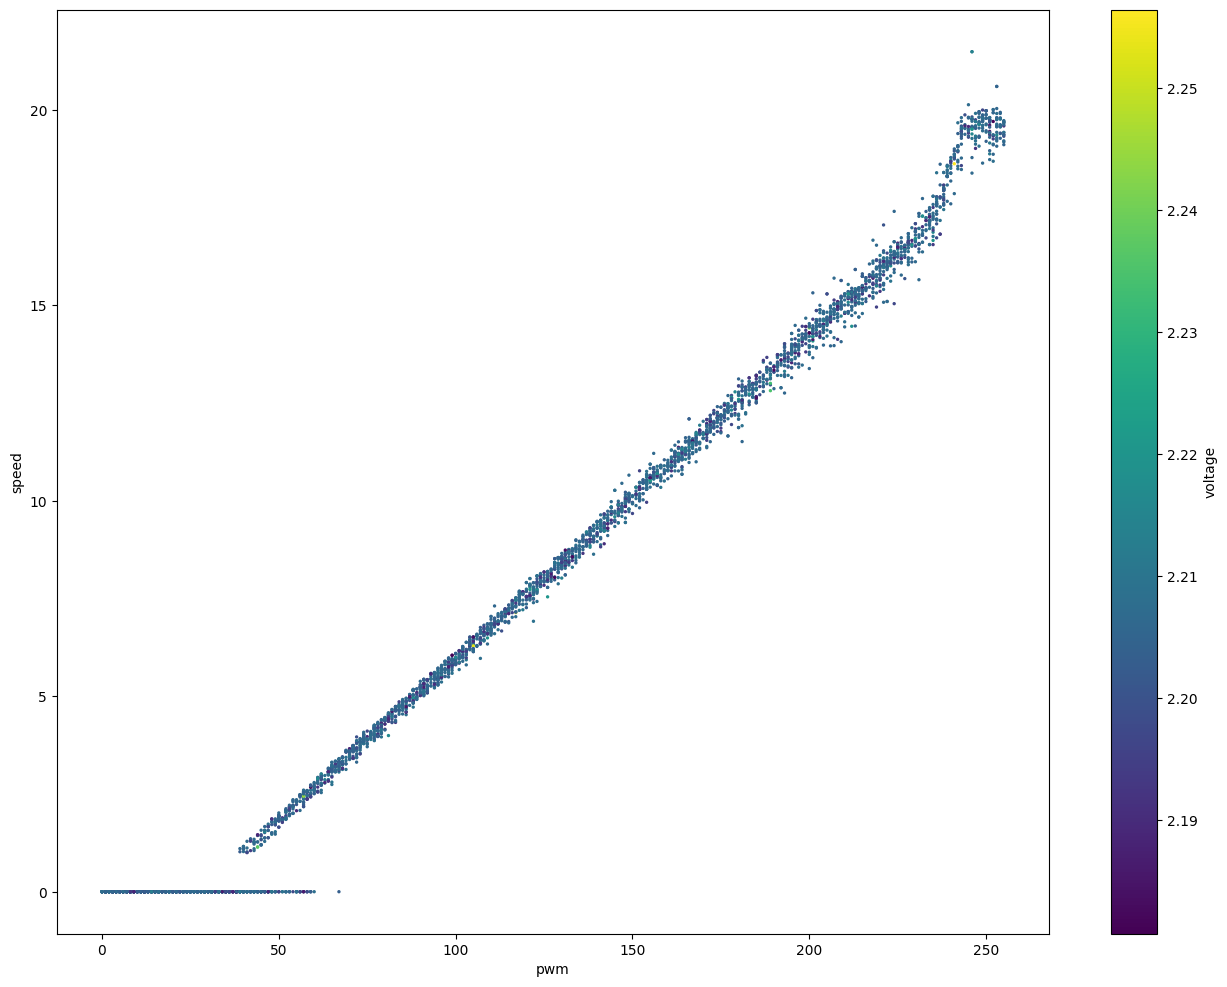

In [80]:
# Scattered plot of pwm, voltage and speed
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 12))
df.plot.scatter(x='pwm', y='speed', c='voltage', colormap='viridis', s=2, ax=ax)
plt.show()

### Zooming in to interesting section 25 to 75 PWM

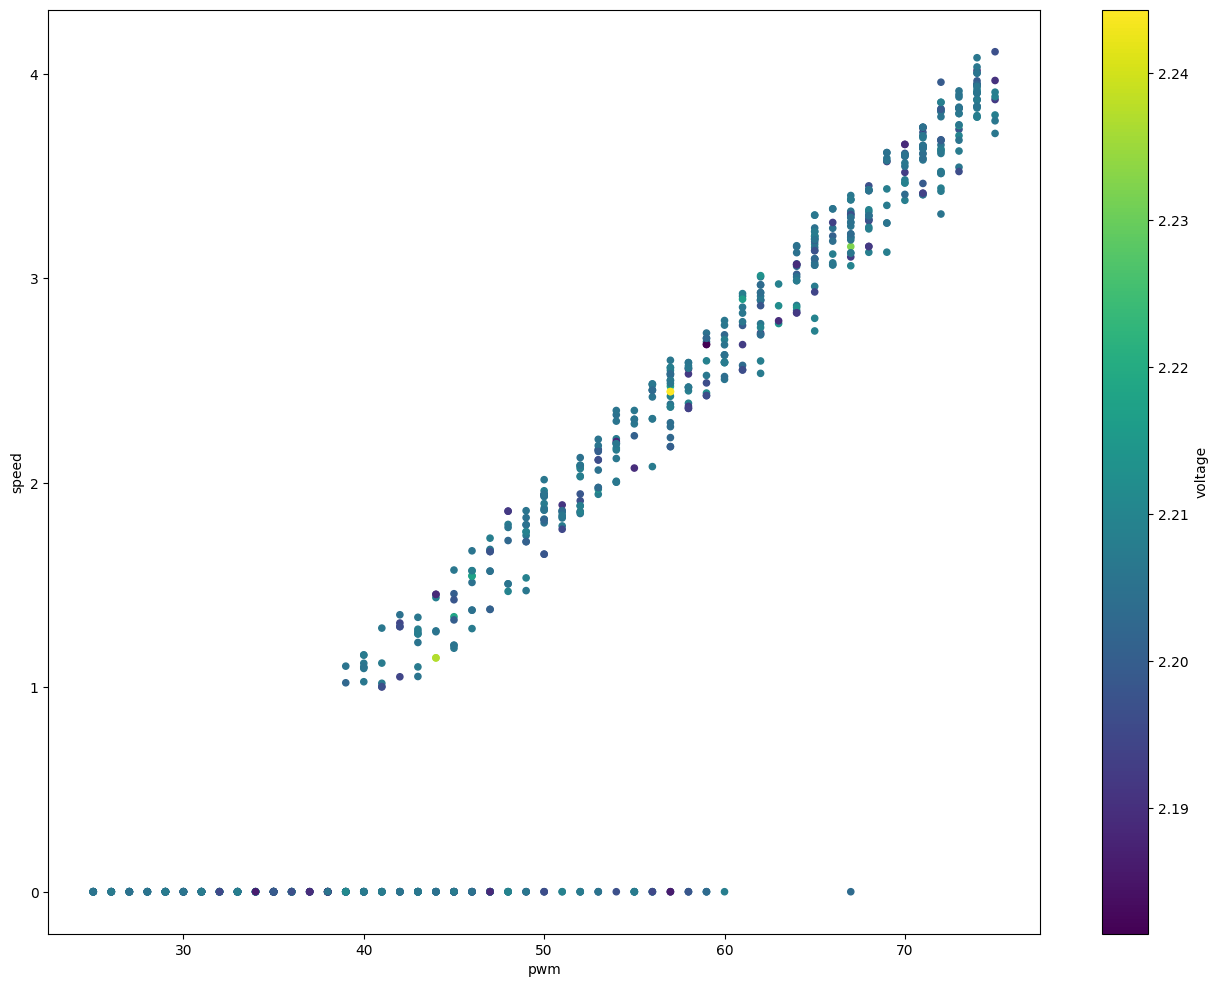

In [81]:
# Zoom to pwm 25 to 75
df_zoom = df[(df['pwm'] >= 25) & (df['pwm'] <= 75)]
fig, ax = plt.subplots(figsize=(16, 12))
df_zoom.plot.scatter(x='pwm', y='speed', c='voltage', colormap='viridis', s=20, ax=ax)
plt.show()

### Zooming in to interesting section over 200 PWM

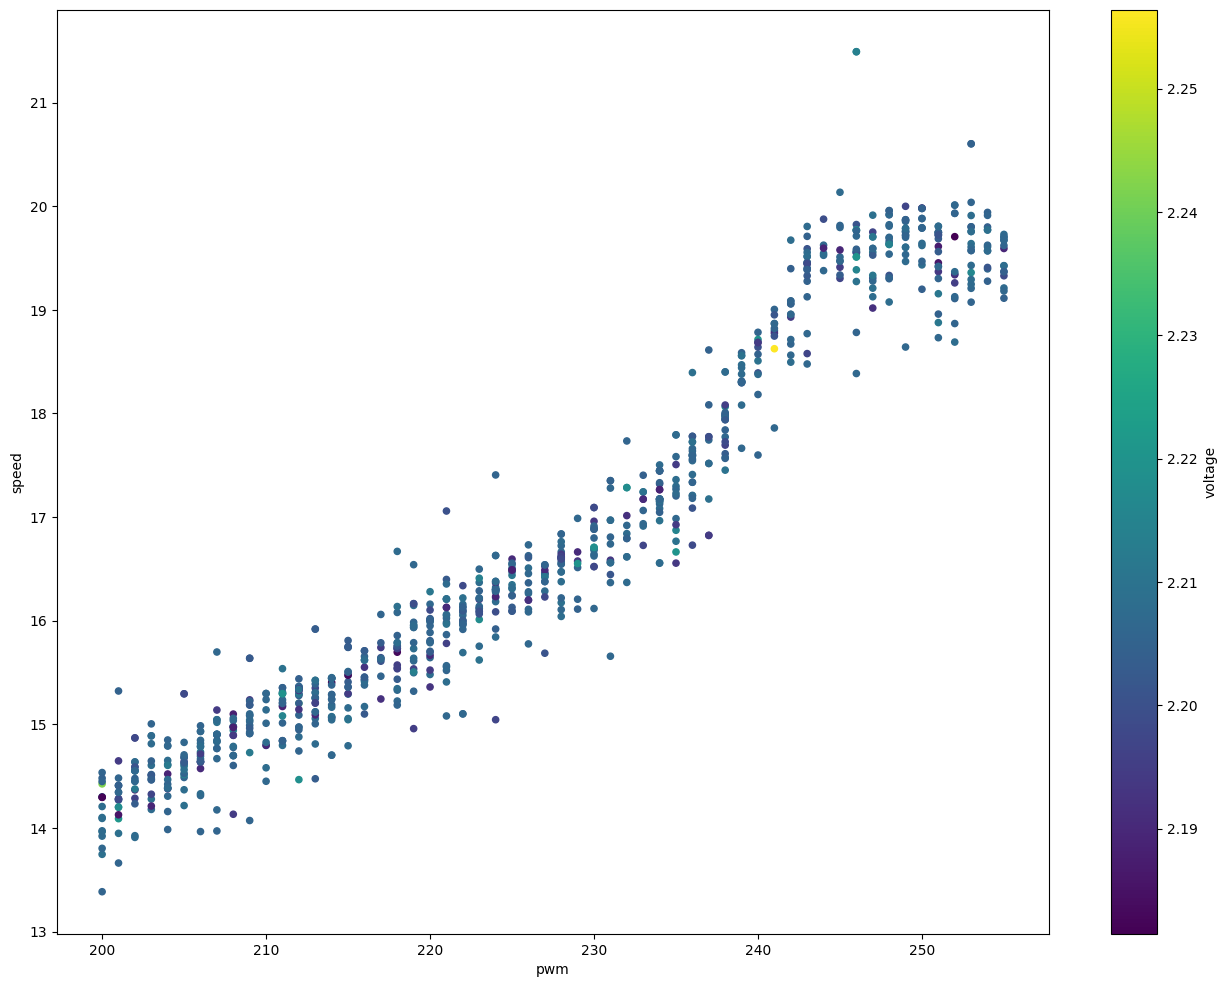

In [82]:
# Zoom to pwm over 200
df_zoom = df[(df['pwm'] >= 200)]
fig, ax = plt.subplots(figsize=(16, 12))
df_zoom.plot.scatter(x='pwm', y='speed', c='voltage', colormap='viridis', s=20, ax=ax)
plt.show()

### Let's see extreme values in voltage ignoring others. Highest 10% to be in green, lowest 10% to be in red.
If there is strong correlation between voltage and speed, we should see some pattern here of green being always on top of the line.

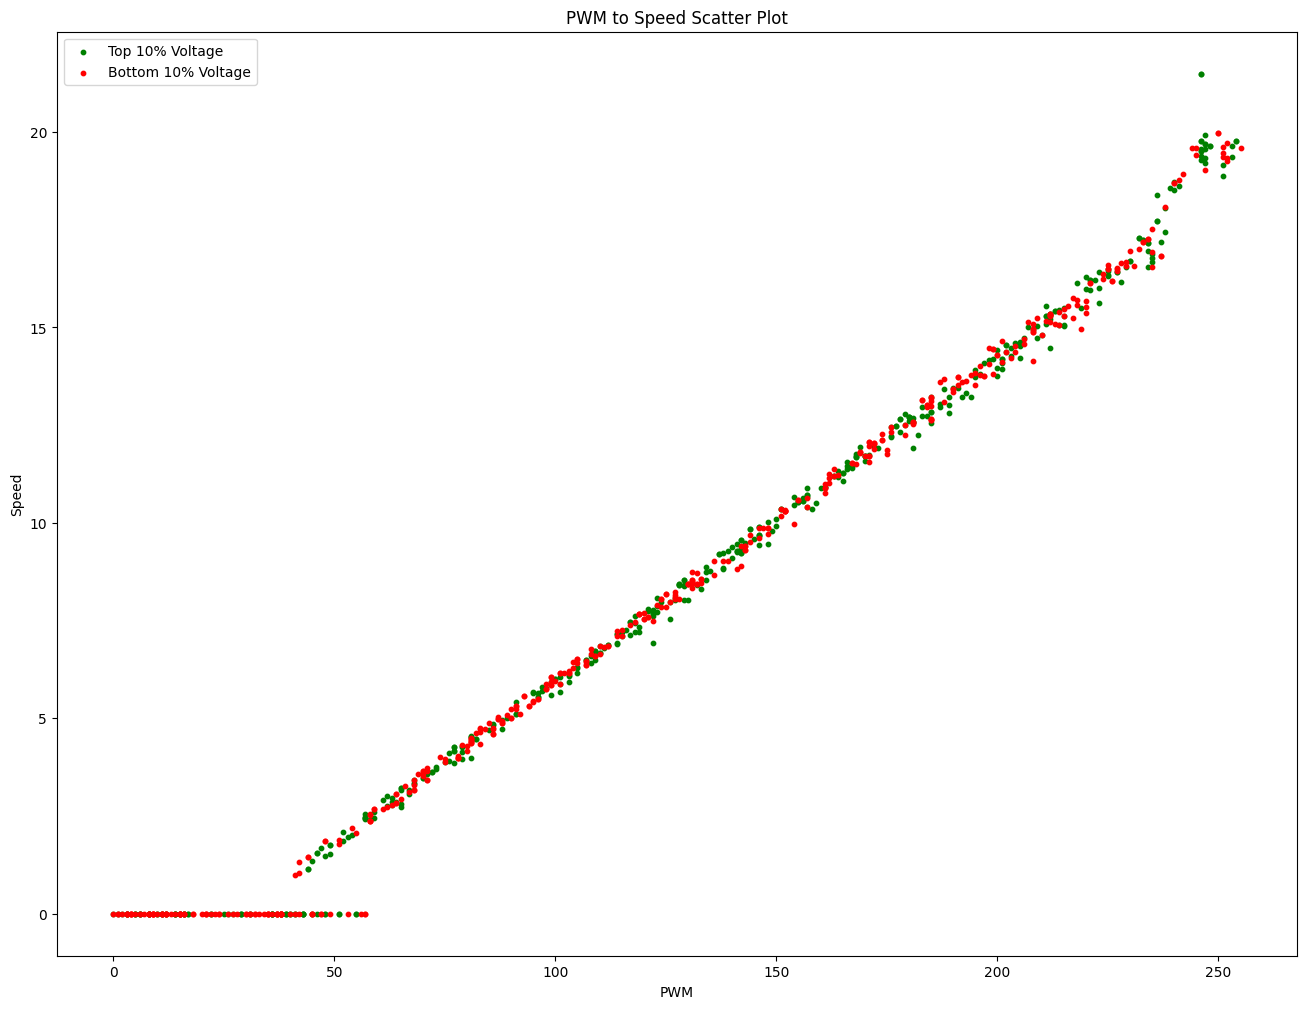

In [83]:
# Filter df rows to include only top 10% and bottom of voltage values
df_top10 = df[df['voltage'] >= df['voltage'].quantile(0.9)]
df_bottom10 = df[df['voltage'] <= df['voltage'].quantile(0.1)]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 12))

# Scatter plot for df_top10 in green
ax.scatter(df_top10['pwm'], df_top10['speed'], color='green', label='Top 10% Voltage', s=10)

# Scatter plot for df_bottom10 in red
ax.scatter(df_bottom10['pwm'], df_bottom10['speed'], color='red', label='Bottom 10% Voltage', s=10)

# Set labels
ax.set_xlabel('PWM')
ax.set_ylabel('Speed')
ax.set_title('PWM to Speed Scatter Plot')

# Add legend
ax.legend()

# Show plot
plt.show()


Let's see sample of fixed pwm (to have more datapoints we will "fix" in in range of 3) on how speed evolves with voltage

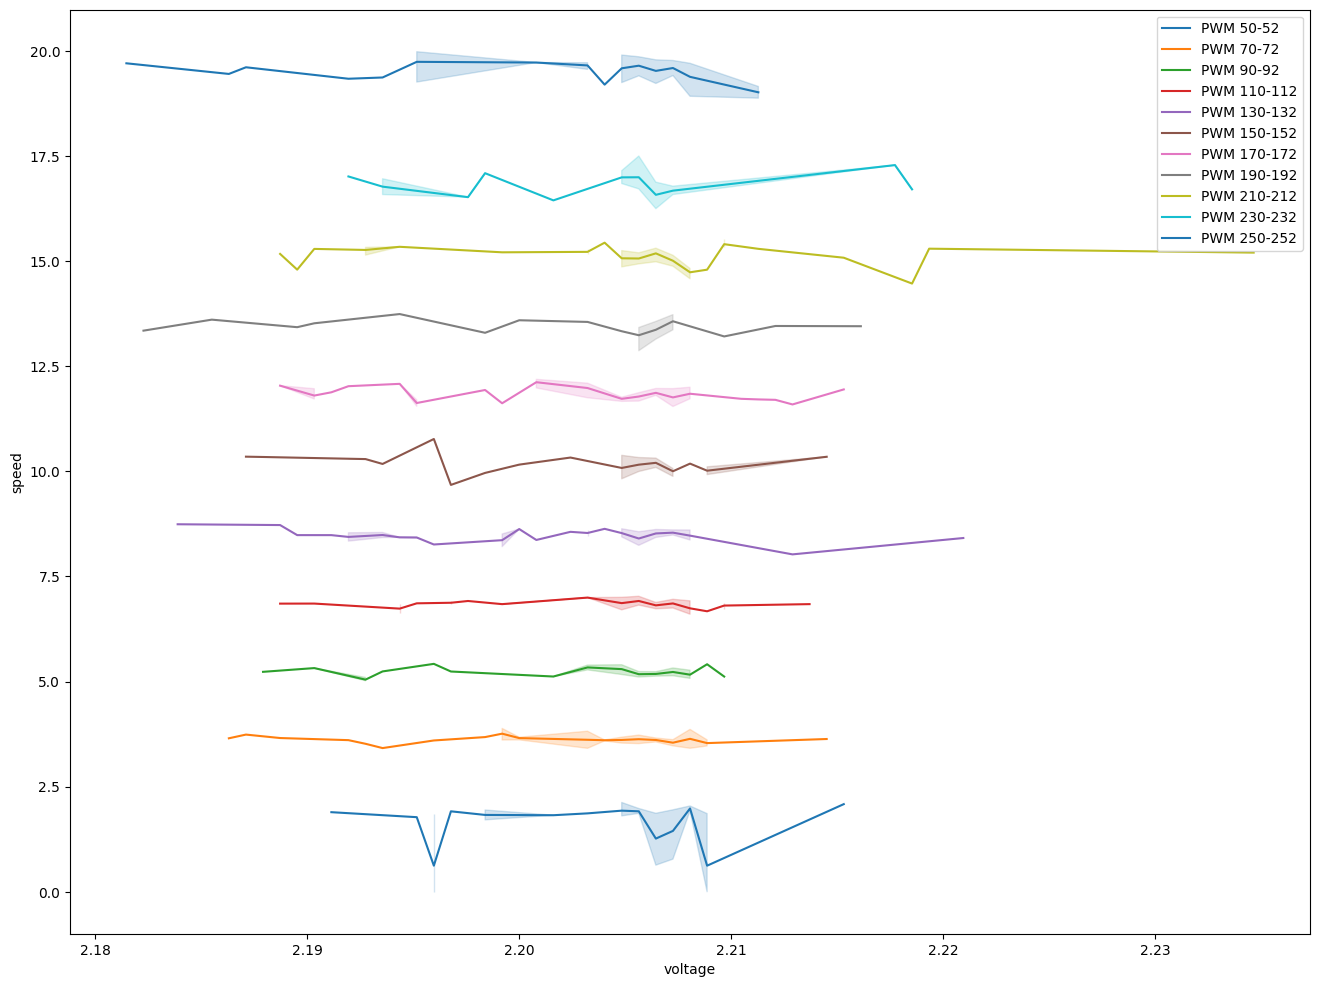

In [84]:

import matplotlib.pyplot as plt
import seaborn as sns

# Define the ranges of pwm
pwm_ranges = [(i, i + 2) for i in range(50, 256, 20)]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 12))

# Plot each range
for pwm_range in pwm_ranges:
    df_zoom = df[(df['pwm'] >= pwm_range[0]) & (df['pwm'] <= pwm_range[1])]
    sns.lineplot(x=df_zoom["voltage"], y=df_zoom["speed"], ax=ax, label=f'PWM {pwm_range[0]}-{pwm_range[1]}')

# Show plot
plt.show()

### Linear Regrestion model training
- Without scaling features -> simplicity of inference on device

In [85]:
# Linear Regression model - take the pwm and voltage to predict speed
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df[['pwm', 'voltage']], df['speed'])

LinearRegression()

In [86]:
# Predict the speed
pwm = 140
voltage = 2.2
model.predict([[pwm, voltage]])

c:\Users\tokubica\AppData\Local\miniconda3\envs\robot\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([9.40395494])

In [87]:
# Print model equation
print(f"speed = {model.intercept_} + {model.coef_[0]} * pwm + {model.coef_[1]} * voltage")

speed = -7.557230152331938 + 0.08215664875990293 * pwm + 2.4814792098348186 * voltage


### Relative importance of pwm vs. voltage to predict speed
Fit the model using scaled features to see relative importance of each feature.

In [88]:
# Linear Regression model - take the pwm and voltage to predict speed
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline that scales the features and then fits the model
pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Fit the model
pipeline.fit(df[['pwm', 'voltage']], df['speed'])

# Print coefficients
pwm_coef, voltage_coef = pipeline.named_steps['linearregression'].coef_

print(f"speed = {pipeline.named_steps['linearregression'].intercept_} + {pwm_coef} * pwm + {voltage_coef} * voltage")

print()
print(f"Relative importance of pwm: {abs(pwm_coef) / (abs(pwm_coef) + abs(voltage_coef))}")
print(f"Relative importance of voltage: {abs(voltage_coef) / (abs(pwm_coef) + abs(voltage_coef))}")

speed = 8.17066179357022 + 6.116156035379288 * pwm + 0.01545208734885098 * voltage

Relative importance of pwm: 0.9974799290757714
Relative importance of voltage: 0.002520070924228582


Plot relative importance of each feature as it evolves over time

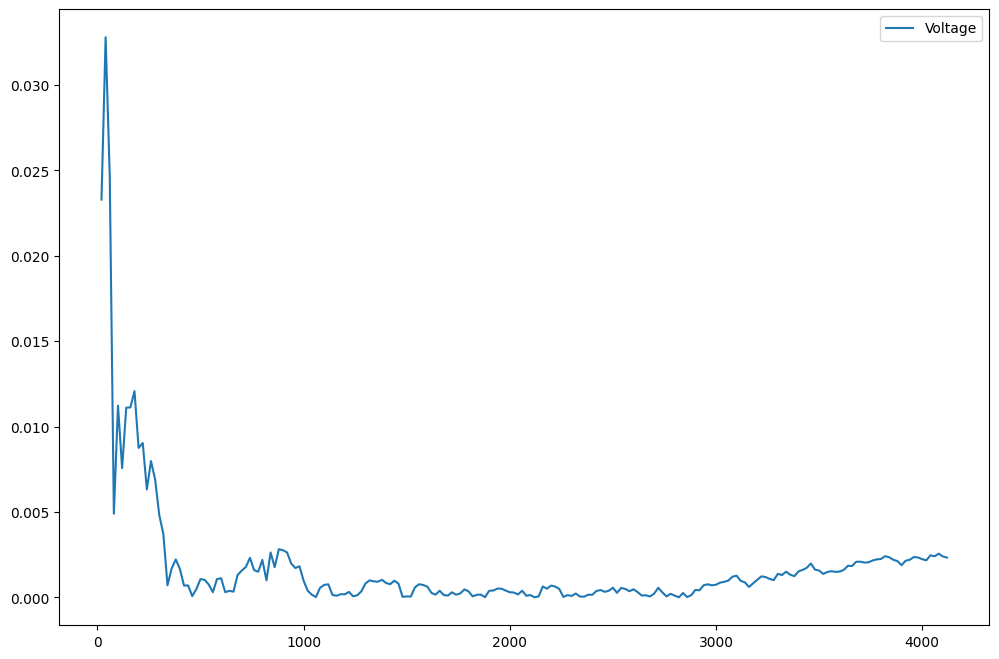

In [89]:
df_size = len(df)
df_step = int(df_size / 200)
df_index = range(df_step, df_size, df_step)

pwm = []
voltage = []
for i in df_index:
    i_df = df.iloc[0:i]
    pipeline.fit(i_df[['pwm', 'voltage']], i_df['speed'])
    pwm_coef, voltage_coef = pipeline.named_steps['linearregression'].coef_
    pwm.append(abs(pwm_coef) / (abs(pwm_coef) + abs(voltage_coef)))
    voltage.append(abs(voltage_coef) / (abs(pwm_coef) + abs(voltage_coef)))

# Plot pwm and voltage over time in line chart
fig, ax = plt.subplots(figsize=(12, 8))
# sns.lineplot(x=df_index, y=pwm, ax=ax, label='PWM')
sns.lineplot(x=df_index, y=voltage, ax=ax, label='Voltage')
plt.show()

